In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

X_elec = Normalizer().fit_transform(df[['HUFL','MUFL','LUFL']])    # Here direction matters
X_therm = 0.5 * StandardScaler().fit_transform(df[['OT']])         # Here magnitude matters

X_initial = np.hstack([X_elec, X_therm])

normalizer = Normalizer(norm='l2')
X = normalizer.fit_transform(X_initial)

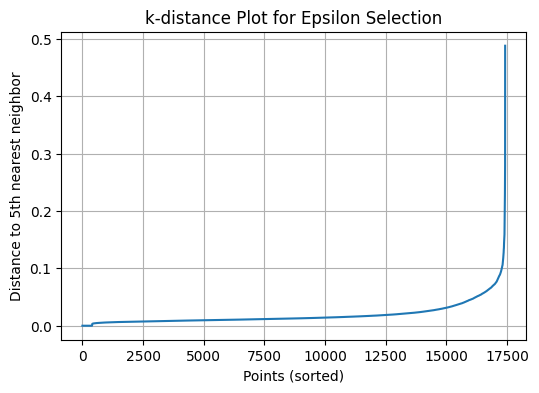

In [2]:
# We are trying to find the ideal value of epsilon in this block of code.

k = 5
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X)

distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-distance Plot for Epsilon Selection")
plt.grid()
plt.show()

The elbow in the k-distance plot provides a heuristic for selecting ε.

In [3]:
# Calculating the ideal value of epsilon

x = np.arange(len(k_distances))
y = k_distances

# Line between first and last point
point1 = np.array([x[0], y[0]])
point2 = np.array([x[-1], y[-1]])

# Compute perpendicular distances
distances_to_line = np.abs(
    np.cross(point2 - point1, point1 - np.vstack((x, y)).T)
) / np.linalg.norm(point2 - point1)

# Elbow index
elbow_index = np.argmax(distances_to_line)
eps_optimal = k_distances[elbow_index]

print(eps_optimal)

0.05959279149767493


In [4]:
clustering = DBSCAN(eps=eps_optimal, min_samples=5, metric = 'cosine')    # Based on the graph.
clustering.fit(X)
df['cluster'] = clustering.labels_

# Finding the number of clusters formed
unique, counts = np.unique(df['cluster'], return_counts=True)
print(dict(zip(unique, counts)))

# Number of anomalies
n_outliers = (df['cluster'] == -1).sum()
print(f"Total anomalies detected: {n_outliers}")

# Noise ratio
noise_ratio = np.mean(df['cluster'] == -1)
print('The noise ratio is: ', noise_ratio, '%')


{-1: 2, 0: 17361, 1: 57}
Total anomalies detected: 2
The noise ratio is:  0.0001148105625717566 %


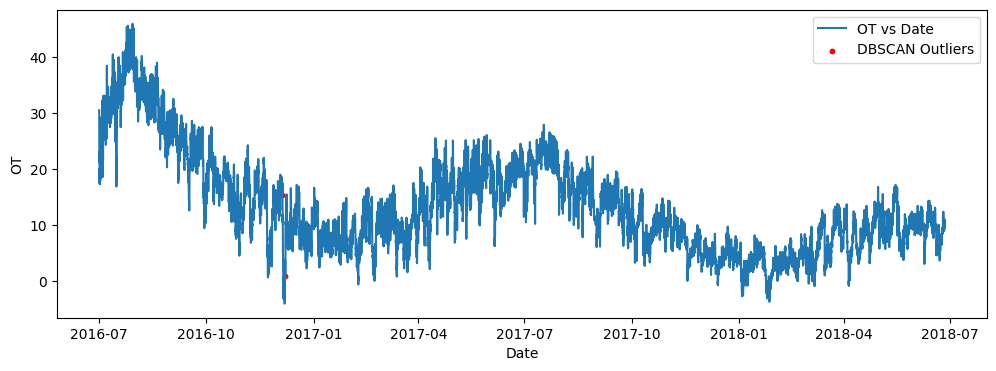

In [5]:
# Plotting the outliers
plt.figure(figsize = (12,4))
plt.plot(df['date'], df['OT'], label = 'OT vs Date')

plt.scatter(
    df.loc[df['cluster'] == -1, 'date'], df.loc[df['cluster'] == -1, 'OT'], color='red', s=10, label='DBSCAN Outliers'
)
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

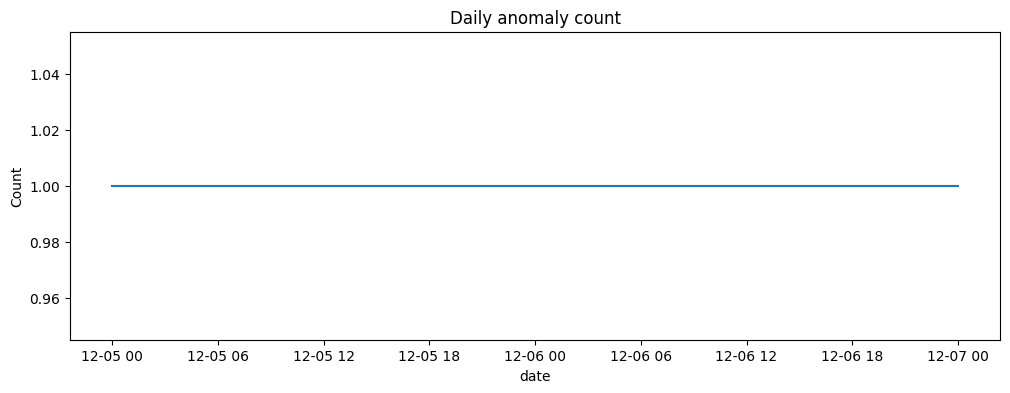

In [6]:
# Anomaly trends
daily_anomalies = df[df['cluster'] == -1].groupby(df['date'].dt.date).size()

plt.figure(figsize=(12,4))
daily_anomalies.plot()
plt.title("Daily anomaly count")
plt.ylabel("Count")
plt.show()